In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.metrics import make_scorer
from pandas.api.types import CategoricalDtype
from time import perf_counter
from xgboost import XGBRegressor


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [2]:
%matplotlib inline
sns.set_theme()

## Loding Data

Load the full car datset. Keep only a subset of columns useful for prediction.
Drop samples with key features missing (mileage, age, price, power). Split the df in train and test. 

In [3]:
file_path = os.path.join("data", "autoscout_dataset.csv")
df_raw = pd.read_csv(file_path, sep=";", index_col="url")

In [11]:
final_col = ['Carburante',
                 'Carrozzeria',
                 'Chilometraggio',
                 'Cilindrata_cm3',
                 'Cilindri',
                 'Colore',
                 'Consumo_comb_L100km',
                 'Consumo_extraurb_L100km',
                 'Consumo_urb_L100km',
                 'Marce',
                 'Peso_a_vuoto_kg',
                 'Tagliandi_certificati',
                 'Tipo_di_cambio',
                 'Trazione',
                 'country',
                 'makeId',
                 'maker',
                 'model',
                 'modelOrModelLineId',
                 'potenza_kw',
                 'price',
                 'unico_proprietario',
                 'zip',
                 'age_years'
            ]

#    .drop(columns=[col for col in df_raw.columns if col not in final_col])

In [12]:
df_clean = (df_raw.astype({'Anno':'datetime64[ns]', 'date':'datetime64[ns]'})
    .assign(age_years= lambda x: (x['date'] - x['Anno']) / np.timedelta64(1, 'Y'))
    .dropna(subset=['price', 'potenza_kw', 'age_years', 'Chilometraggio'])
)  

In [7]:
df_train, df_test = train_test_split(df_clean, test_size=0.1)

## Loss Functions

In [8]:
def rmse_loss(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def rmspe_loss(y_true, y_pred):
    return np.mean((y_true-y_pred)**2/y_true**2)**0.5

def mape_loss(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))

rmse = make_scorer(rmse_loss, greater_is_better=False)
mae = make_scorer(mean_absolute_error, greater_is_better=False)
rmspe = make_scorer(rmspe_loss, greater_is_better=False)
mape = make_scorer(mape_loss, greater_is_better=False)

In [9]:
def show_losses(y_true, y_pred):
    d = {}
    d['rmse'] = [rmse_loss(y_true, y_pred)]
    d['rmspe'] = [rmspe_loss(y_true, y_pred)]
    d['mae'] = [mean_absolute_error(y_true, y_pred)]
    d['mape'] = [mape_loss(y_true, y_pred)]
    d['medae'] = [median_absolute_error(y_true, y_pred)]
    d['max_ae'] = [np.max(np.abs(y_true-y_pred))]
    d['max_pe'] = [np.max(np.abs(y_true-y_pred)/y_true)]
    
    df = pd.DataFrame(data=d)
    display(df)
    

## Baseline

Most simple baseline: using the mean/median as prediciton

In [9]:
price_mean = float(df_train['price'].mean())
price_median = float(df_train['price'].median())

In [10]:
print('Baseline Mean')
show_losses(df_test['price'].to_numpy(), np.ones(len(df_test))*price_mean)

print('Baseline Median')
show_losses(df_test['price'].to_numpy(), np.ones(len(df_test))*price_median)

Baseline Mean


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,18689.578293,323.776221,10822.501873,5.811855,8152.459088,473347.540912,21651.459088


Baseline Median


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,19089.384058,252.707459,10070.649597,4.504453,6801.0,478100.0,16899.0


## Manual exploration of models

In [11]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(columns=['price']), 
                                                    df_train['price'], 
                                                    test_size=0.2, random_state=42
                                                   )

In [12]:
num_features = ['age_years', 'potenza_kw', 'Chilometraggio', 'Cilindrata_cm3']
cat_features = ['Tipo_di_cambio', 'Trazione', 'Carrozzeria', 'Carburante']

In [13]:
#Numerical features pipeline
num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)


#Categorical features pipeline
cat_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

# Preprocessing pipeline
preprocessor = make_column_transformer(
    (num_transformer, num_features),
    (cat_transformer, cat_features),
    remainder='drop'
)

## Linear Models

In [14]:
# Full model pipeline
lm_model = make_pipeline(
    preprocessor,
    LinearRegression()    
)

In [15]:
lm_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age_years', 'potenza_kw',
                                                   'Chilometraggio',
                                                   'Cilindrata_cm3']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                

In [16]:
#Linear model predictions
y_train_lmp = lm_model.predict(X_train)
y_val_lmp = lm_model.predict(X_val)

In [17]:
print('Train Set')
show_losses(y_train, y_train_lmp)

print('Test Set')
show_losses(y_val, y_val_lmp)

Train Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,83384.126204,295.256771,7124.105279,4.319576,4126.659198,9.985036e+06,31125.864625


Test Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,19776.488533,36.344796,6146.416868,0.983987,4068.713257,1.434216e+06,3134.666659


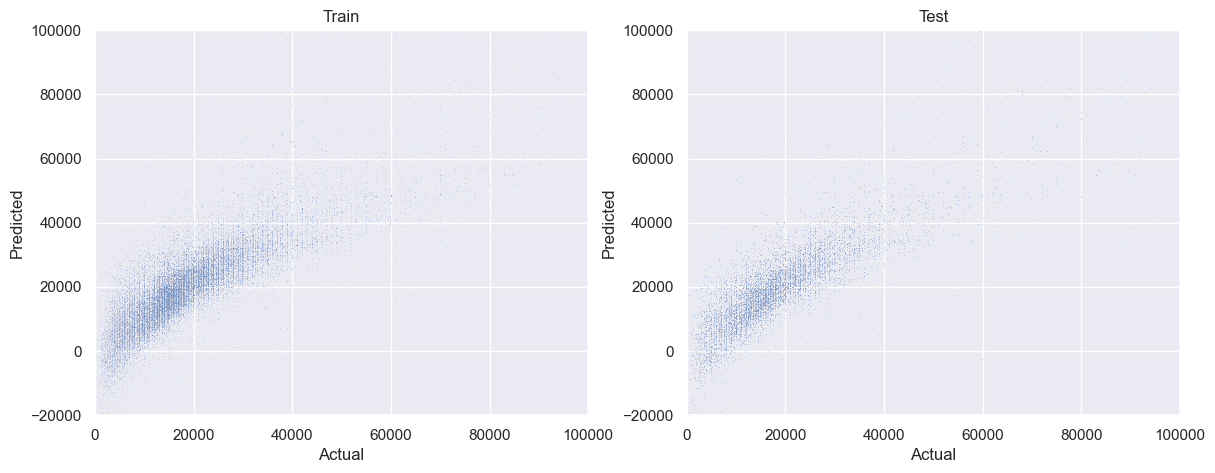

In [18]:
MAX_PRICE = 1e5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(x=y_train, y=y_train_lmp, s=0.1, ax=ax1)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set(xlim=[0, MAX_PRICE], ylim=[-2e4, MAX_PRICE], title='Train')
sns.scatterplot(x=y_val, y=y_val_lmp, s=0.2, ax=ax2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set(xlim=[0, MAX_PRICE], ylim=[-2e4, MAX_PRICE], title='Test');

## Random Forest Model

In [19]:
# Full model pipeline
rf_model = make_pipeline(
    preprocessor,
    RandomForestRegressor()    
)

In [20]:
rf_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age_years', 'potenza_kw',
                                                   'Chilometraggio',
                                                   'Cilindrata_cm3']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                

In [21]:
#Random forest predictions
y_train_rfp = rf_model.predict(X_train)
y_val_rfp = rf_model.predict(X_val)

In [22]:
print('Train Set')
show_losses(y_train, y_train_rfp)

print('Test Set')
show_losses(y_val, y_val_rfp)

Train Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,33698.283019,91.18984,1527.59519,1.193219,375.435,4494735.78,10796.43


Test Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,21987.535952,62.600864,2907.740428,0.952832,1030.92,1434016.0,5555.8


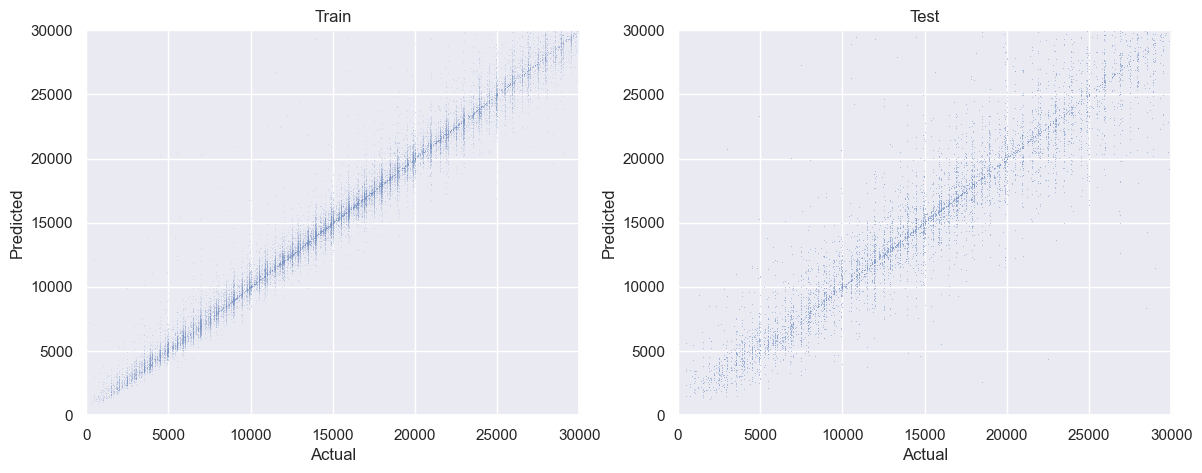

In [23]:
MAX_PRICE = 0.3e5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(x=y_train, y=y_train_rfp, s=0.1, ax=ax1)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set(xlim=[0, MAX_PRICE], ylim=[0, MAX_PRICE], title='Train')
sns.scatterplot(x=y_val, y=y_val_rfp, s=0.3, ax=ax2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set(xlim=[0, MAX_PRICE], ylim=[0, MAX_PRICE], title='Test');

## XGB Model

In [24]:
# Full model pipeline
xg_model = make_pipeline(
    preprocessor,
    XGBRegressor()    
)

In [25]:
xg_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age_years', 'potenza_kw',
                                                   'Chilometraggio',
                                                   'Cilindrata_cm3']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                

In [26]:
#XGB predictions
y_train_xgp = xg_model.predict(X_train)
y_val_xgp = xg_model.predict(X_val)

In [27]:
print('Train Set')
show_losses(y_train, y_train_xgp)

print('Test Set')
show_losses(y_val, y_val_xgp)

Train Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,4492.134156,200.565988,2395.054117,2.315496,1570.931641,219324.0,27098.494141


Test Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,25025.854663,66.100207,3575.400036,0.972218,1703.023438,1.432689e+06,5922.753418


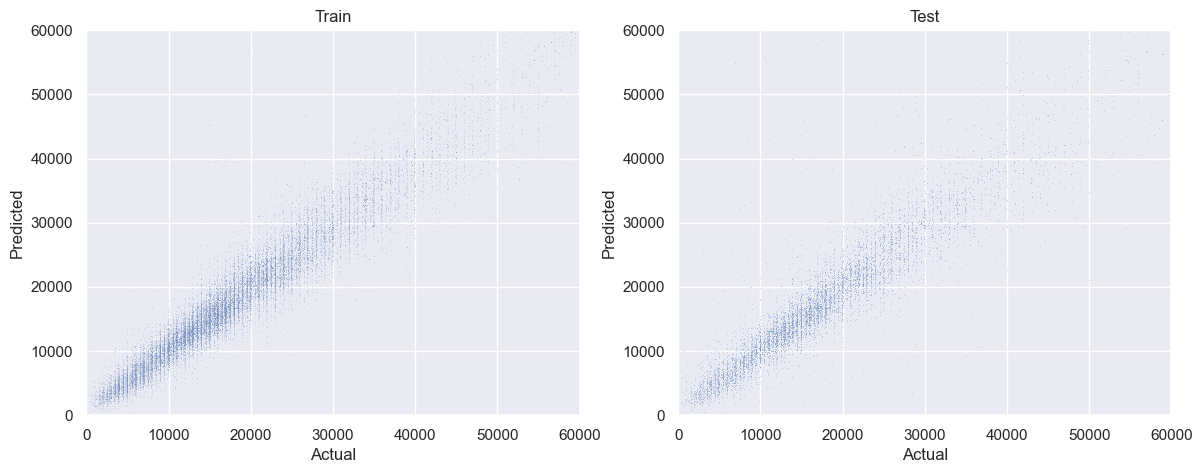

In [28]:
MAX_PRICE = 0.6e5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(x=y_train, y=y_train_xgp, s=0.1, ax=ax1)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set(xlim=[0, MAX_PRICE], ylim=[0, MAX_PRICE], title='Train')
sns.scatterplot(x=y_val, y=y_val_xgp, s=0.2, ax=ax2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set(xlim=[0, MAX_PRICE], ylim=[0, MAX_PRICE], title='Test');

## Pycaret 

In [15]:
from pycaret.regression import *

In [35]:
df_raw.columns

Index(['Acconto', 'Anno', 'Carburante', 'Carrozzeria', 'Chilometraggio',
       'Cilindrata_cm3', 'Cilindri', 'Colore', 'Comfort',
       'Consumo_comb_L100km', 'Consumo_extraurb_L100km', 'Consumo_urb_L100km',
       'Emissioni_CO2_gKm', 'Extra', 'Intrattenimento__Media', 'Marce',
       'Peso_a_vuoto_kg', 'Porte', 'Posti', 'Prezzo_auto', 'Sicurezza',
       'Tagliandi_certificati', 'Tipo_di_cambio', 'Tipo_di_veicolo',
       'Trazione', 'city', 'country', 'countryCode', 'date', 'garanzia_mesi',
       'makeId', 'maker', 'model', 'modelOrModelLineId', 'modelVersionInput',
       'potenza_cv', 'potenza_kw', 'price', 'street', 'unico_proprietario',
       'zip'],
      dtype='object')

In [32]:
exp_reg_pc = setup(data = df_train, 
                   target = 'price', 
                   session_id=123,
                   normalize = True, transformation = True, transform_target = True,
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   feature_selection = True,
                   fold_shuffle=True,
                   numeric_features = ['Marce', 'Posti', 'Porte', 'Cilindri'],
                   ignore_features=['country', 'countryCode','date', 'street',
                                    'potenza_cv', 'Prezzo_auto',
                                    'makeId', 'modelOrModelLineId', 'Extra', 'Intrattenimento__Media',
                                    'Consumo_extraurb_L100km', 'Consumo_urb_L100km', 'Sicurezza', 'Colore',
                                   'garanzia_mesi', 'modelVersionInput', 'zip', 'Comfort', 'city', 'Anno'],
                   high_cardinality_features=['maker', 'model'],
                   bin_numeric_features = ['Marce', 'Posti', 'Porte', 'Cilindri'],
                   remove_outliers = True,
                   combine_rare_levels = True,
                   polynomial_features=True,
                   unknown_categorical_method='most_frequent'
                  )

,Description,Value
0,session_id,123
1,Target,price
2,Original Data,"(44717, 42)"
3,Missing Values,True
4,Numeric Features,12
5,Categorical Features,9
6,Ordinal Features,False
7,High Cardinality Features,True
8,High Cardinality Method,frequency
9,Transformed Train Set,"(29736, 64)"


In [38]:
get_config('X').columns

Index(['Marce_4.0', 'Trazione_Integrale', 'Tipo_di_veicolo_KM0',
       'Peso_a_vuoto_kg', 'Tipo_di_cambio_Automatico', 'Carburante_Elettrica',
       'Marce_10.0', 'Cilindri_7.0', 'Posti_8.0', 'Posti_10.0',
       'Tipo_di_veicolo_Aziendale', 'Acconto', 'Carrozzeria_Berlina',
       'Porte_4.0', 'Tipo_di_cambio_not_available', 'Marce_11.0', 'Porte_6.0',
       'potenza_kw', 'Emissioni_CO2_gKm', 'Carrozzeria_Monovolume',
       'Marce_7.0', 'Tipo_di_cambio_Manuale', 'Marce_8.0',
       'Carrozzeria_City Car', 'Posti_5.0', 'Marce_1.0',
       'Tipo_di_veicolo_Usato', 'Porte_1.0', 'Trazione_not_available',
       'Carrozzeria_Furgone', 'Consumo_comb_L100km_Power2',
       'Carburante_Ibrida', 'Cilindrata_cm3', 'age_years_Power2',
       'Carrozzeria_Station Wagon', 'Cilindri_Power2', 'Carburante_Metano',
       'Marce_0.0', 'Marce_5.0', 'Posti_4.0', 'Carrozzeria_Cabrio',
       'Chilometraggio', 'Carrozzeria_SUV/Fuoristrada', 'Marce_9.0',
       'Carrozzeria_Coupe', 'Carburante_Benzina',

In [8]:
best = compare_models(n_select = 3, 
                        include=['lr', 'ridge', 'knn', 'par', 'svm', 'rf', 'lightgbm', 'ada', 'xgboost', 'catboost'],
                        sort = 'MAPE',
                        budget_time=10,
                        fold = 3
                     )

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,801.1469,74785492.2833,4992.8446,0.1728,0.0759,0.4843,3.5933
xgboost,Extreme Gradient Boosting,2866.0076,4089477510.6667,43398.6410,0.4721,0.2290,1.5984,4.5833
ada,AdaBoost Regressor,6842.4897,4226813133.9454,47044.5235,0.2160,0.4873,1.7482,2.0200
rf,Random Forest Regressor,2725.5593,4140908563.6371,44135.8889,0.4296,0.2354,1.8105,9.8867
lightgbm,Light Gradient Boosting Machine,3046.7335,4141020831.6750,44137.3923,0.4304,0.2371,1.9439,1.1867
ridge,Ridge Regression,4060.0824,4165395212.0000,44934.9062,0.3840,0.3012,1.9680,5.2400
svm,Support Vector Regression,3194.9045,4147946007.8458,44364.3472,0.4181,0.2518,1.9710,36.9533
par,Passive Aggressive Regressor,5317.9334,4186786297.5310,45886.0736,0.3143,0.3627,2.2240,3.9833
knn,K Neighbors Regressor,3868.0486,4155884983.0260,44835.8115,0.3901,0.3009,2.2293,10.1067


### Exploring catboost and xgboost

In [10]:
ctb = create_model('catboost', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2270.6512,23800973.5418,4878.6241,0.9089,0.2508,3.9899
1,2564.3293,679660675.5099,26070.3026,0.2991,0.1928,0.1248
2,2237.9237,82353594.6220,9074.8881,0.6702,0.2381,0.3830
3,2294.7065,32619344.3171,5711.3347,0.8589,0.1902,0.1236
4,3704.4728,2960143389.6680,54407.1998,0.0975,0.2100,0.1258
5,2097.8428,15417844.6120,3926.5563,0.9307,0.2379,2.9544
6,5962.8803,37287978585.0412,193100.9544,0.0050,0.2186,0.1253
7,2256.2723,45611221.6748,6753.6080,0.8249,0.2560,8.2895
8,2336.9459,29989716.0646,5476.2867,0.8544,0.1953,0.1295


In [11]:
xgb = create_model('xgboost', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2235.6624,21508566.0000,4637.7329,0.9176,0.2480,3.9525
1,2508.8738,428347296.0000,20696.5527,0.5583,0.2037,0.1278
2,2211.3579,76427144.0000,8742.2617,0.6940,0.2411,0.4011
3,2346.7029,34045428.0000,5834.8462,0.8527,0.1996,0.1249
4,3713.3738,2954759936.0000,54357.7031,0.0991,0.2149,0.1251
5,2121.0515,16206528.0000,4025.7332,0.9271,0.2418,2.9915
6,5927.1519,37295087616.0000,193119.3594,0.0048,0.2251,0.1255
7,2252.3381,61260504.0000,7826.9092,0.7648,0.2650,8.6563
8,2257.2170,28018544.0000,5293.2544,0.8640,0.1974,0.1262


In [12]:
tuned_ctb = tune_model(ctb, n_iter = 25)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2124.2407,26807626.8425,5177.6082,0.8973,0.2527,3.7747
1,2305.9508,490543540.3283,22148.2175,0.4941,0.1879,0.1159
2,2086.9702,74663653.3338,8640.8132,0.7010,0.2435,0.4059
3,2211.2511,38400762.5485,6196.8349,0.8339,0.1946,0.1183
4,3518.1251,2936508901.6348,54189.5645,0.1047,0.2103,0.1171
5,1957.2593,16012242.5410,4001.5300,0.9280,0.2339,2.9318
6,5764.8267,37286507872.5807,193097.1462,0.0050,0.2176,0.1169
7,2073.8335,59059064.6533,7684.9896,0.7732,0.2599,8.5562
8,2177.8242,33440136.2748,5782.7447,0.8377,0.1978,0.1222


In [13]:
tuned_xgb = tune_model(xgb, n_iter = 25)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2321.0457,27652880.0000,5258.6006,0.8941,0.2597,2.7686
1,2583.3430,622749952.0000,24954.9590,0.3578,0.2047,0.1300
2,2147.5222,74499088.0000,8631.2852,0.7017,0.2438,0.3003
3,2380.1001,33956600.0000,5827.2290,0.8531,0.2018,0.1268
4,3666.5317,3021892864.0000,54971.7461,0.0787,0.2227,0.1249
5,2093.1340,16064990.0000,4008.1155,0.9278,0.2438,2.5573
6,5872.6821,37285920768.0000,193095.6250,0.0050,0.2300,0.1267
7,2244.6006,53391820.0000,7306.9707,0.7950,0.2662,8.5572
8,2327.8149,36773308.0000,6064.1001,0.8215,0.2132,0.1341


In [115]:
#save_model(tuned_ctb,'Final Catboost Model')
#save_model(tuned_xgb,'Final XGboost Model')

In [17]:
tuned_xgb = load_model('Final XGboost Model')
tuned_ctb = load_model('Final Catboost Model')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [29]:
train_prediction = predict_model(tuned_xgb, data=df_train)
test_prediction = predict_model(tuned_xgb, data=df_test)

In [28]:
test_prediction.head()

,Acconto,Anno,Carburante,Carrozzeria,Chilometraggio,Cilindrata_cm3,Cilindri,Colore,Comfort,Consumo_comb_L100km,Consumo_extraurb_L100km,Consumo_urb_L100km,Emissioni_CO2_gKm,Extra,Intrattenimento__Media,Marce,Peso_a_vuoto_kg,Porte,Posti,Prezzo_auto,Sicurezza,Tagliandi_certificati,Tipo_di_cambio,Tipo_di_veicolo,Trazione,city,country,countryCode,date,garanzia_mesi,makeId,maker,model,modelOrModelLineId,modelVersionInput,potenza_cv,potenza_kw,price,street,unico_proprietario,zip,age_years,Label
url,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mercedes-benz-v-220-cdi-7-posti-diesel-grigio-965eb555-ead9-43d9-bca9-9e209c310be1,2500.0,2004-02-01,Diesel,Monovolume,300000.0,2151.0,4.0,Grigio,Alzacristalli elettrici;Bracciolo;Climatizzato...,7.5,6.3,9.6,NaN,Cerchi in lega;Cerchioni in acciaio;Gancio tra...,Autoradio;CD;MP3;Sound system,NaN,2010.0,5.0,7.0,9500.0,ABS;Airbag conducente;Airbag passeggero;Antifu...,False,Manuale,Usato,NaN,Ranzanico - Bergamo - BG,Italy,IT,2022-12-28 15:50:42.223349,NaN,47,Mercedes-Benz,V,15945.0,220 cdi 7 Posti,122.0,90.0,9500.0,Via Nazionale,False,24060.0,18.907055,3767.844238
fiat-panda-1-2-easy-neopatentati-solo-39000-km-benzina-arancione-bfb8a8b1-66cb-4611-839b-4f4db1086926,0.0,2018-07-01,Benzina,Berlina,39000.0,1242.0,4.0,Arancione,Alzacristalli elettrici;Climatizzatore,5.1,4.3,6.6,119.0,NaN,Autoradio;Computer di bordo,5.0,1015.0,5.0,4.0,10800.0,ABS;Airbag conducente;Airbag passeggero;Airbag...,False,Manuale,Usato,Anteriore,Borgo San Giacomo - BS,Italy,IT,2023-01-03 17:57:50.584803,12.0,28,Fiat,Panda,1746.0,1.2 Easy NEOPATENTATI-SOLO 39000 KM,69.0,51.0,10800.0,Zaghen Auto,False,25022.0,4.511382,10590.401367
fiat-bravo-bravo-1-6-mjt-easy-120cv-dualogic-diesel-argento-30caef99-da2b-4381-8c70-d256d5bde605,0.0,2012-07-01,Diesel,Berlina,142440.0,1598.0,4.0,Argento,Alzacristalli elettrici;Bracciolo;Climatizzato...,4.6,3.8,5.9,120.0,"Cerchi in lega (17"");Controllo vocale;Ruotino",Autoradio;Bluetooth;Computer di bordo;MP3;Soun...,6.0,1320.0,5.0,5.0,7100.0,ABS;Airbag conducente;Airbag laterali;Airbag p...,False,Semiautomatico,Usato,Anteriore,Meda - Monza Brianza - Mb,Italy,IT,2022-12-12 15:58:20.249499,12.0,28,Fiat,Bravo,1741.0,Bravo 1.6 mjt Easy 120cv dualogic,120.0,88.0,7100.0,Via Vignazzola 51,True,20821.0,10.449675,7271.863281
ford-ecosport-ecosport-1-5-tdci-titanium-95cv-e6-diesel-2a691799-852c-4158-a0d0-be37cd372bc7,0.0,2016-04-01,Diesel,Altro,64083.0,NaN,4.0,NaN,NaN,3.8,NaN,4.4,86.0,NaN,NaN,5.0,NaN,5.0,5.0,13900.0,NaN,False,Manuale,Usato,NaN,Milano-MI,Italy,IT,2022-12-15 10:23:51.248663,12.0,29,Ford,EcoSport,20303.0,ecosport 1.5 tdci Titanium 95cv E6,95.0,70.0,13900.0,Via Privata dell'Innominato,True,20142.0,6.706320,14287.411133
volvo-v40-cross-country-d2-1-6-powershift-summum-navi-automatica-diesel-grigio-fa5da394-e99a-4ec8-ae5e-13c8e3ffd27e,0.0,2015-01-01,Diesel,Berlina,125000.0,1560.0,4.0,Grigio,Alzacristalli elettrici;Bracciolo;Climatizzato...,4.1,3.9,4.5,108.0,"Cerchi in lega (18"");Controllo vocale",Autoradio;Bluetooth;CD;MP3;USB,6.0,1386.0,5.0,5.0,NaN,ABS;Airbag conducente;Airbag laterali;Airbag p...,False,Automatico,Usato,Anteriore,Curno - Bergamo - Bg,Italy,IT,2022-12-13 17:35:16.719997,NaN,73,Volvo,V40 Cross Country,20296.0,"D2 1.6 Powershift Summum\""NAVI\""AUTOMATICA\""",116.0,85.0,15500.0,Via E.Fermi 32,False,24035.0,7.950150,15563.221680


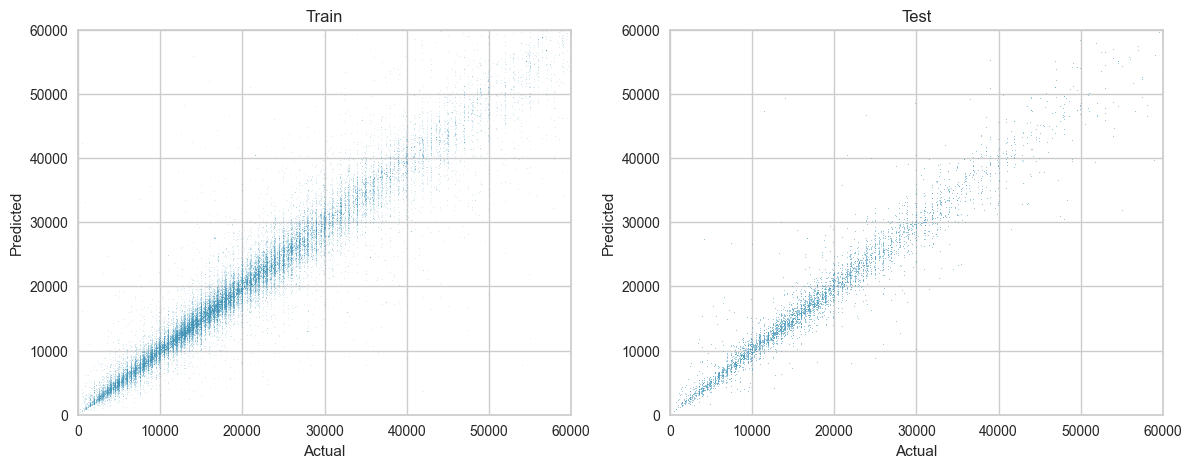

In [32]:
MAX_PRICE = 0.6e5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(train_prediction, x='price', y='Label', s=0.1, ax=ax1)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set(xlim=[0, MAX_PRICE], ylim=[0, MAX_PRICE], title='Train')
sns.scatterplot(test_prediction, x='price', y='Label', s=0.3, ax=ax2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set(xlim=[0, MAX_PRICE], ylim=[0, MAX_PRICE], title='Test');